In [1]:
print("Hello, Colab!")

Hello, Colab!


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np

# For splitting data and scaling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns

# For balancing data classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Logistic Regression model and evaluation metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report
from sklearn.feature_selection import RFE



In [7]:
# Load the dataset
file_path = '/content/drive/My Drive/nlp/dataset_final/daily_news/mrk/MRK_numerical.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(data.head())


        Price   Open  Close   High     Volume
0      Ticker    MRK    MRK    MRK        MRK
1        Date    NaN    NaN    NaN        NaN
2  2020-06-10   66.8  66.26  67.07  9080920.0
3  2020-06-09  67.41  66.65  67.67  8846168.0
4  2020-06-08  65.75  67.17  67.41  9956838.0


In [8]:
# Check for missing values
print(data.isnull().sum())

# Summary statistics of the dataset
print(data.describe())


Price     0
Open      1
Close     1
High      1
Volume    1
dtype: int64
             Price   Open  Close   High     Volume
count         2740   2739   2739   2739       2739
unique        2740   1886   1904   1885       2718
top     2009-07-27  21.47  20.53  21.51  7456101.0
freq             1      7      7      7          3


In [10]:
import pandas as pd

# Step 1: Skip the first two junk rows and create a clean copy
data_cleaned = data.iloc[2:].copy()

# Step 2: Rename the 'Price' column to 'Date'
data_cleaned.rename(columns={'Price': 'Date'}, inplace=True)

# Step 3: Convert the 'Date' column to a proper datetime format
data_cleaned['Date'] = pd.to_datetime(data_cleaned['Date'])

# Now, you can sort by the 'Date' column without an error
data_cleaned = data_cleaned.sort_values(by='Date', ascending=True)

# Optional: Convert other columns to numeric if needed
for col in ['Open', 'Close', 'High', 'Volume']:
    data_cleaned[col] = pd.to_numeric(data_cleaned[col], errors='coerce')

# Display the head of the cleaned and sorted DataFrame
print(data_cleaned.head())

           Date   Open  Close   High      Volume
2739 2009-07-27  17.26  17.07  17.29  21026758.0
2738 2009-07-28  17.03  16.65  17.14  23627265.0
2737 2009-07-29  16.64  16.57  16.72  16696736.0
2736 2009-07-30  16.76  16.61  17.18  24300290.0
2735 2009-07-31  16.75  16.64  16.96  16269362.0


In [12]:
import pandas as pd

# --- FIX: Convert columns to a numeric type before calculations ---
# Use errors='coerce' to turn any non-numeric values into NaN (Not a Number)
data['Open'] = pd.to_numeric(data['Open'], errors='coerce')
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')

# Calculate next-day return
data['Movement'] = ((data['Open'].shift(-1) - data['Close']) / data['Close'])

# Shift Movement to align with current day's features
data['Movement'] = data['Movement'].shift(1)

# Drop rows with NaN values that were created during calculations
data = data.dropna(subset=['Movement'])

# Convert Movement into a binary target variable (1 for up, 0 for down/flat)
data['Movement'] = (data['Movement'] > 0).astype(int)

# Check the distribution of the target variable
print("Distribution of the 'Movement' target variable:")
print(data['Movement'].value_counts().sort_index())

Distribution of the 'Movement' target variable:
Movement
0    1457
1    1280
Name: count, dtype: int64


/tmp/ipython-input-89519153.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Movement'] = (data['Movement'] > 0).astype(int)


In [13]:
# Calculate daily returns (in percentage)
data['Daily_Return'] = data['Close'].pct_change() * 100

# Choose a rolling window (e.g., 10 days) for volatility
window_size = 5
data['Volatility'] = data['Daily_Return'].rolling(window=window_size).std()

# Drop the initial NaNs from rolling calculation
data = data.dropna(subset=['Volatility'])

/tmp/ipython-input-3981640151.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Daily_Return'] = data['Close'].pct_change() * 100
/tmp/ipython-input-3981640151.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Volatility'] = data['Daily_Return'].rolling(window=window_size).std()


In [14]:
# Create lagged features to avoid data leakage
data['Close_lag1'] = data['Close'].shift(1)
data['High_lag1'] = data['High'].shift(1)
data['Volume_lag1'] = data['Volume'].shift(1)
data['Daily_Return_lag1'] = data['Daily_Return'].shift(1)
data['Volatility_lag1'] = data['Volatility'].shift(1)

# Drop rows with NaN values introduced by shifting
data = data.dropna(subset=['Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1'])


In [18]:
data.tail(20)


,Price,Open,Close,High,Volume,Movement,Daily_Return,Volatility,Close_lag1,High_lag1,Volume_lag1,Daily_Return_lag1,Volatility_lag1
2720,2009-08-21,17.55,18.06,18.15,21721372.0,0,0.166389,1.180070,18.03,18.3,14227229.0,-1.367615,1.199370
2721,2009-08-20,17.55,17.38,17.55,16164562.0,0,-3.765227,1.779439,18.06,18.15,21721372.0,0.166389,1.180070
2722,2009-08-19,17.00,17.46,17.7,21322294.0,0,0.460299,1.888431,17.38,17.55,16164562.0,-3.765227,1.779439
2723,2009-08-18,17.12,17.03,17.12,12926032.0,0,-2.462772,1.777563,17.46,17.7,21322294.0,0.460299,1.888431
2724,2009-08-17,16.97,17.13,17.39,19584290.0,0,0.587199,1.987353,17.03,17.12,12926032.0,-2.462772,1.777563
2725,2009-08-14,17.19,17.18,17.24,16942178.0,1,0.291886,2.006511,17.13,17.39,19584290.0,0.587199,1.987353
2726,2009-08-13,17.04,17.18,17.18,14137939.0,0,0.000000,1.270307,17.18,17.24,16942178.0,0.291886,2.006511
2727,2009-08-12,16.83,17.05,17.19,12899518.0,0,-0.756694,1.221920,17.18,17.18,14137939.0,0.000000,1.270307
2728,2009-08-11,16.89,16.82,17.07,11423829.0,0,-1.348974,0.793948,17.05,17.19,12899518.0,-0.756694,1.221920
2729,2009-08-10,16.80,16.97,17.19,19050963.0,0,0.891795,0.880738,16.82,17.07,11423829.0,-1.348974,0.793948


In [19]:
data.columns

Index(['Price', 'Open', 'Close', 'High', 'Volume', 'Movement', 'Daily_Return',
       'Volatility', 'Close_lag1', 'High_lag1', 'Volume_lag1',
       'Daily_Return_lag1', 'Volatility_lag1'],
      dtype='object')

In [20]:
# Rename the 'Price' column to 'Date'
data.rename(columns={'Price': 'Date'}, inplace=True)

# Verify the change by printing the columns again
print(data.columns)

Index(['Date', 'Open', 'Close', 'High', 'Volume', 'Movement', 'Daily_Return',
       'Volatility', 'Close_lag1', 'High_lag1', 'Volume_lag1',
       'Daily_Return_lag1', 'Volatility_lag1'],
      dtype='object')


In [23]:
# Correlation Metrics
# Specify the columns of interest for correlation with 'Movement'
columns_of_interest = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1',
                        'Daily_Return_lag1', 'Volatility_lag1']

# Calculate the correlation between 'Movement' and each of the specified columns
correlation_with_movement = data[columns_of_interest + ['Movement']].corr()['Movement']

# Drop the self-correlation of 'Movement'
correlation_with_movement = correlation_with_movement.drop('Movement')

# Display the correlation values
print(correlation_with_movement)


Open                 0.032486
Close_lag1           0.001049
High_lag1            0.008104
Volume_lag1          0.039450
Daily_Return_lag1   -0.029747
Volatility_lag1      0.071177
Name: Movement, dtype: float64


In [24]:
# Define features (X) and target (y)
features = ['Open', 'Close_lag1', 'High_lag1', 'Volume_lag1', 'Daily_Return_lag1', 'Volatility_lag1']
X = data[features]
y = data['Movement']

# Inspect the feature set
print(X.head())
print(y.head())


     Open  Close_lag1 High_lag1 Volume_lag1  Daily_Return_lag1  \
9   64.97       65.50     65.52  11352984.0          -1.488946   
10  64.38       64.46     65.19   6269241.0          -1.587786   
11  63.69       65.40     65.58  13517104.0           1.458269   
12  62.39       64.04     65.06  13180906.0          -2.079511   
13  63.41       62.84     62.91  12828987.0          -1.873829   

    Volatility_lag1  
9          0.993890  
10         0.882498  
11         1.350375  
12         1.555610  
13         1.456981  
9     0
10    0
11    0
12    0
13    1
Name: Movement, dtype: int64


***Splitting and scaling the data***

In [25]:
# Ensure the 'Date' column is in datetime format
data['Date'] = pd.to_datetime(data['Date'])  # Ensure correct datetime format
data.set_index('Date', inplace=True)
print(data.index)


DatetimeIndex(['2020-06-01', '2020-05-29', '2020-05-28', '2020-05-27',
               '2020-05-26', '2020-05-22', '2020-05-21', '2020-05-20',
               '2020-05-19', '2020-05-18',
               ...
               '2009-08-07', '2009-08-06', '2009-08-05', '2009-08-04',
               '2009-08-03', '2009-07-31', '2009-07-30', '2009-07-29',
               '2009-07-28', '2009-07-27'],
              dtype='datetime64[ns]', name='Date', length=2731, freq=None)


In [26]:
X.index = data.index
print(X.index)

DatetimeIndex(['2020-06-01', '2020-05-29', '2020-05-28', '2020-05-27',
               '2020-05-26', '2020-05-22', '2020-05-21', '2020-05-20',
               '2020-05-19', '2020-05-18',
               ...
               '2009-08-07', '2009-08-06', '2009-08-05', '2009-08-04',
               '2009-08-03', '2009-07-31', '2009-07-30', '2009-07-29',
               '2009-07-28', '2009-07-27'],
              dtype='datetime64[ns]', name='Date', length=2731, freq=None)


In [28]:
# Initialize TimeSeriesSplit
tss = TimeSeriesSplit(n_splits=5)
# Initialize lists to store train and test years
train_years = []
test_years = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Map the integer indices back to the DatetimeIndex
    train_dates = X.index[train_index]
    test_dates = X.index[test_index]

    # Store the dates
    train_years.append(train_dates)
    test_years.append(test_dates)

    # Print the date range for each fold (optional)
    print(f"Fold {fold + 1}:")
    print(f"Train Dates: {train_dates.min().strftime('%Y-%m-%d')} to {train_dates.max().strftime('%Y-%m-%d')}")
    print(f"Test Dates: {test_dates.min().strftime('%Y-%m-%d')} to {test_dates.max().strftime('%Y-%m-%d')}")
    print("-" * 50)


Fold 1:
Train Dates: 2018-08-08 to 2020-06-01
Test Dates: 2016-10-17 to 2018-08-07
--------------------------------------------------
Fold 2:
Train Dates: 2016-10-17 to 2020-06-01
Test Dates: 2014-12-26 to 2016-10-14
--------------------------------------------------
Fold 3:
Train Dates: 2014-12-26 to 2020-06-01
Test Dates: 2013-03-08 to 2014-12-24
--------------------------------------------------
Fold 4:
Train Dates: 2013-03-08 to 2020-06-01
Test Dates: 2011-05-16 to 2013-03-07
--------------------------------------------------
Fold 5:
Train Dates: 2011-05-16 to 2020-06-01
Test Dates: 2009-07-27 to 2011-05-13
--------------------------------------------------


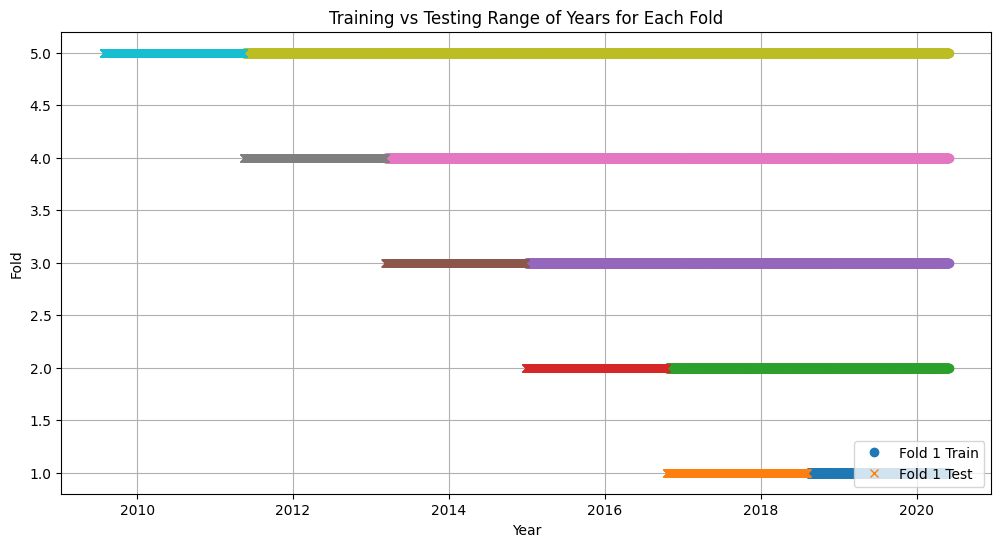

In [30]:
# Plot training vs testing years
plt.figure(figsize=(12, 6))

for i, (train, test) in enumerate(zip(train_years, test_years)):
    plt.plot(train, [i + 1] * len(train), 'o', label=f'Fold {i + 1} Train' if i == 0 else "")
    plt.plot(test, [i + 1] * len(test), 'x', label=f'Fold {i + 1} Test' if i == 0 else "")

plt.xlabel('Year')
plt.ylabel('Fold')
plt.title('Training vs Testing Range of Years for Each Fold')
plt.legend(loc='lower right')
plt.grid()
plt.show()



Fold 1 Confusion Matrix:
[[190  30]
 [  0 235]]


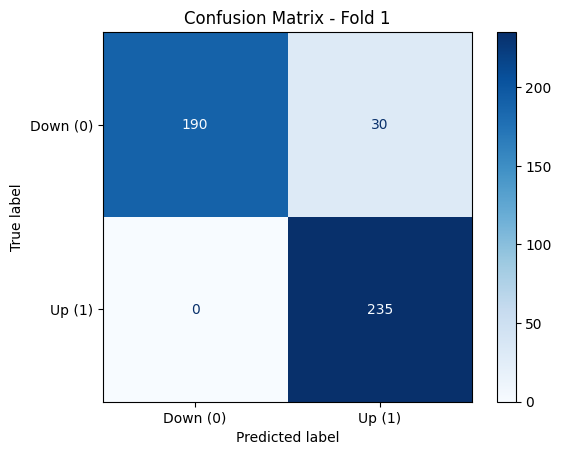

Fold 1 Accuracy: 0.93
--------------------------------------------------

Fold 2 Confusion Matrix:
[[174  65]
 [  0 216]]


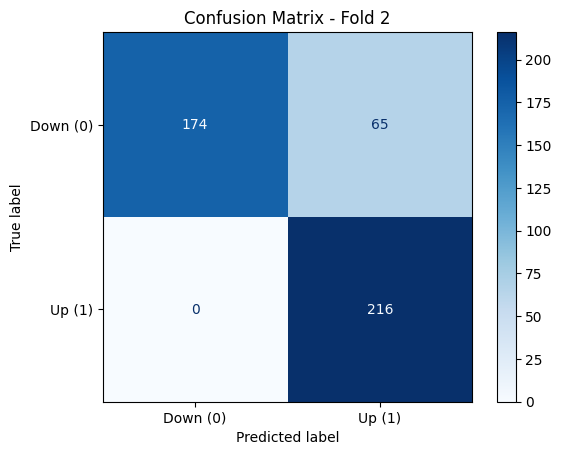

Fold 2 Accuracy: 0.86
--------------------------------------------------

Fold 3 Confusion Matrix:
[[243  15]
 [ 15 182]]


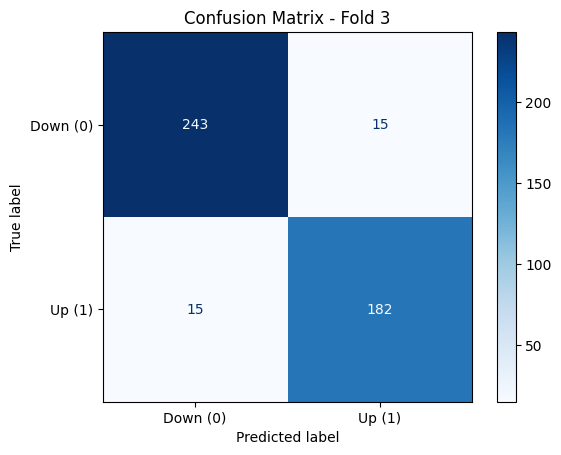

Fold 3 Accuracy: 0.93
--------------------------------------------------

Fold 4 Confusion Matrix:
[[241  13]
 [ 58 143]]


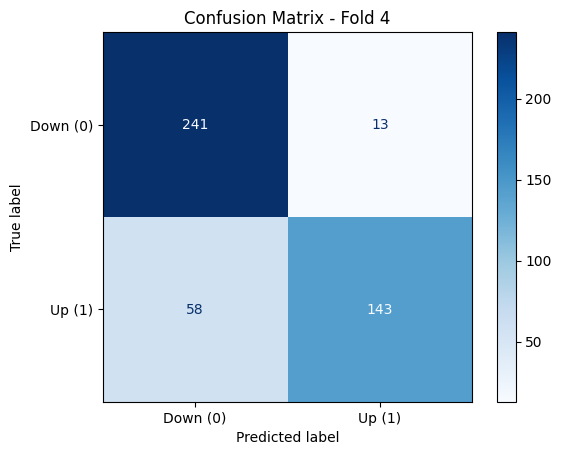

Fold 4 Accuracy: 0.84
--------------------------------------------------

Fold 5 Confusion Matrix:
[[231   8]
 [ 93 123]]


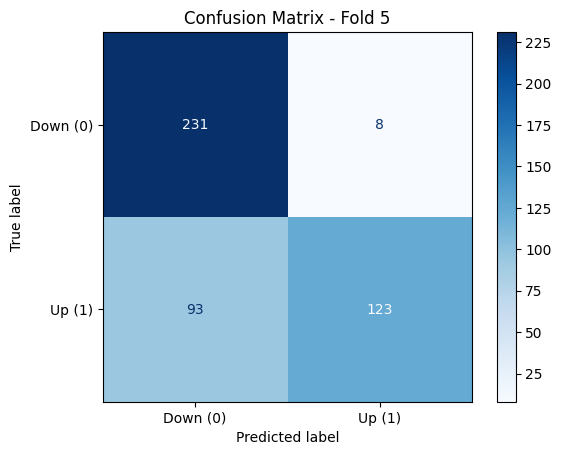

Fold 5 Accuracy: 0.78
--------------------------------------------------

Average Metrics Across Folds:
Accuracy: 0.87
Precision: 0.89
Recall: 0.84
F1-Score: 0.85
ROC-AUC: 0.97


In [31]:
# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)

# Print average metrics
print("\nAverage Metrics Across Folds:")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


Fold 1 - Balanced Class Distribution:
Movement
0    214
1    214
Name: count, dtype: int64
--------------------------------------------------

Fold 1 Confusion Matrix:
[[160  60]
 [  0 235]]


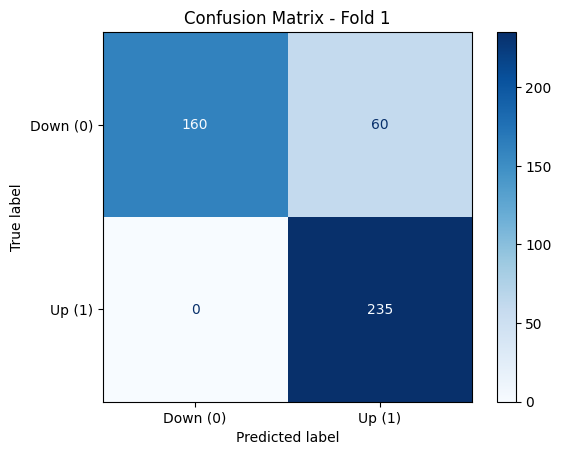

Fold 1 Accuracy: 0.87
--------------------------------------------------
Fold 2 - Balanced Class Distribution:
Movement
0    449
1    449
Name: count, dtype: int64
--------------------------------------------------

Fold 2 Confusion Matrix:
[[160  79]
 [  0 216]]


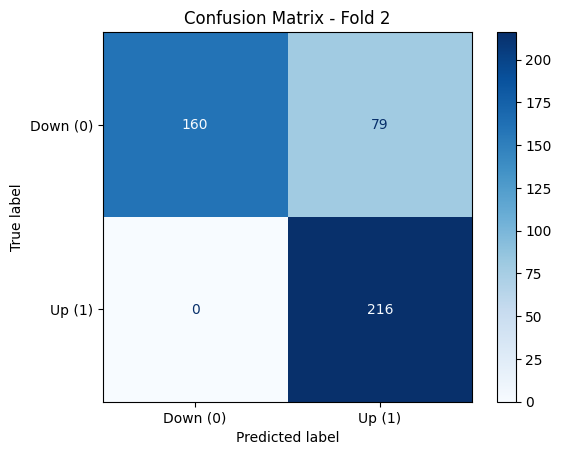

Fold 2 Accuracy: 0.83
--------------------------------------------------
Fold 3 - Balanced Class Distribution:
Movement
0    665
1    665
Name: count, dtype: int64
--------------------------------------------------

Fold 3 Confusion Matrix:
[[236  22]
 [ 11 186]]


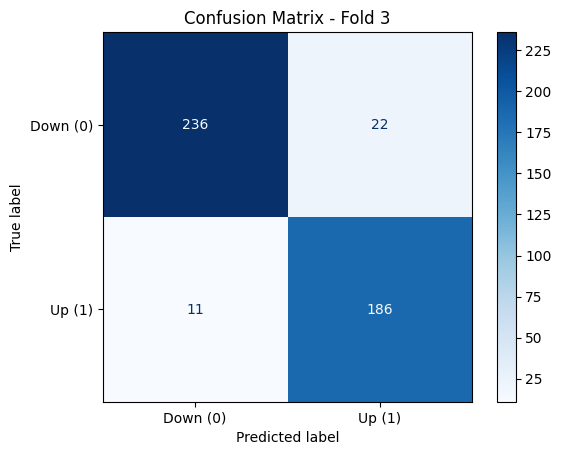

Fold 3 Accuracy: 0.93
--------------------------------------------------
Fold 4 - Balanced Class Distribution:
Movement
0    862
1    862
Name: count, dtype: int64
--------------------------------------------------

Fold 4 Confusion Matrix:
[[235  19]
 [ 30 171]]


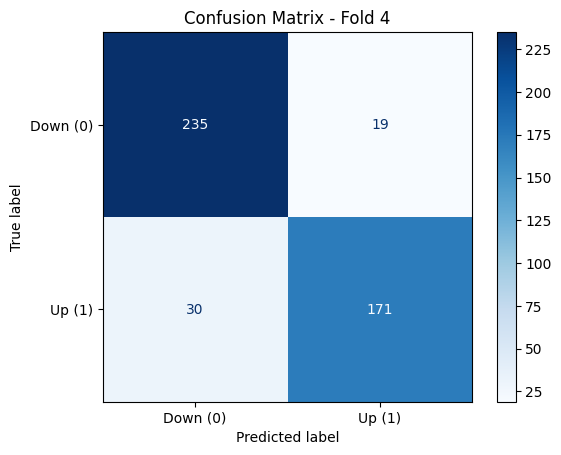

Fold 4 Accuracy: 0.89
--------------------------------------------------
Fold 5 - Balanced Class Distribution:
Movement
0    1063
1    1063
Name: count, dtype: int64
--------------------------------------------------

Fold 5 Confusion Matrix:
[[215  24]
 [ 52 164]]


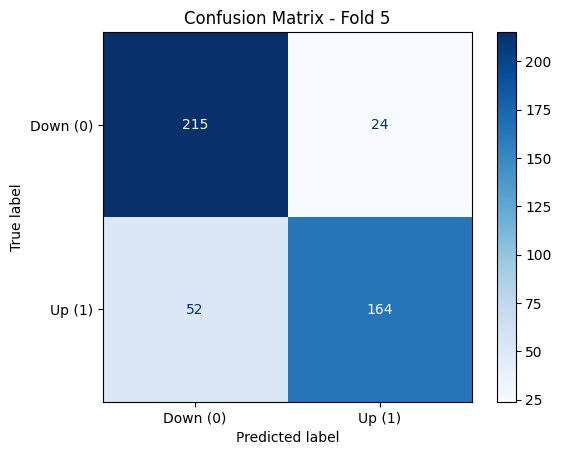

Fold 5 Accuracy: 0.83
--------------------------------------------------

Average Metrics Across Folds (Balanced Data):
Accuracy: 0.87
Precision: 0.84
Recall: 0.91
F1-Score: 0.87
ROC-AUC: 0.97


In [32]:
# Initialize SMOTE for balancing the dataset
undersampler = RandomUnderSampler(random_state=42)

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
roc_auc_scores = []

# Perform TimeSeriesSplit
for fold, (train_index, test_index) in enumerate(tss.split(X)):
    # Split data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Balance the training data
    X_train_balanced, y_train_balanced = undersampler.fit_resample(X_train, y_train)

    # Print class distribution for the balanced training data
    print(f"Fold {fold + 1} - Balanced Class Distribution:")
    print(y_train_balanced.value_counts())
    print("-" * 50)

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_balanced)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the Logistic Regression model
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train_balanced)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    # Append metrics for each fold
    accuracy_scores.append(accuracy)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    roc_auc_scores.append(roc_auc)

    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nFold {fold + 1} Confusion Matrix:")
    print(cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down (0)", "Up (1)"])
    disp.plot(cmap="Blues")
    disp.ax_.set_title(f"Confusion Matrix - Fold {fold + 1}")
    plt.show()

    # Print accuracy for the fold
    print(f"Fold {fold + 1} Accuracy: {accuracy:.2f}")
    print("-" * 50)


# Print average metrics
print("\nAverage Metrics Across Folds (Balanced Data):")
print(f"Accuracy: {sum(accuracy_scores) / len(accuracy_scores):.2f}")
print(f"Precision: {sum(precision_scores) / len(precision_scores):.2f}")
print(f"Recall: {sum(recall_scores) / len(recall_scores):.2f}")
print(f"F1-Score: {sum(f1_scores) / len(f1_scores):.2f}")
print(f"ROC-AUC: {sum(roc_auc_scores) / len(roc_auc_scores):.2f}")


In [33]:
data.to_csv('/content/drive/My Drive/nlp/dataset_final/daily_news/mrk/MRK_numerical_LR.csv')